In [2]:
import sys
sys.path.insert(1, '../evaluator')

import gc
import copy
import itertools
import random as rndm
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
from evaluator import *
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline

In [3]:
'''
evaluator.py
IMPORTS:

getTurbLoc(TURB_LOC_file_name)

loadPowerCurve(POWER_CURVE_file_name)

binWindResourceData(WIND_DATA_file_name)

searchSorted(lookup, sample_array)

preProcessing(POWER_CURVE)

getAEP(TURB_DIAM, turb_coords, POWER_CURVE, WIND_INST_FREQ,
       N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
       
checkConstraints(turb_coords, TURB_DIAM)

'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
TURB_SPECS    =  {
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
TURB_DIAM      =  TURB_SPECS['Dia (m)']
TURB_DIAM       =  TURB_DIAM/2

# Load the power curve
POWER_CURVE   =  loadPowerCurve('./../evaluator/power_curve.csv')

# Pass wind data csv file location to function binWindResourceData.
# Retrieve probabilities of wind instance occurence.
WIND_INST_FREQ =  binWindResourceData('./../evaluator/wind_data/wind_data_2007.csv')

# Doing preprocessing to avoid the same repeating calculations. Record
# the required data for calculations. Do that once. Data are set up (shaped)
# to assist vectorization. Used later in function totalAEP.
N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t = preProcessing(POWER_CURVE)

# check if there is any constraint is violated before we do anything. 
def evalPrint(turbine_coordinates):
    checkConstraints(turbine_coordinates, TURB_DIAM)
    
    print('[INFO] Calculating AEP')
    AEP = getAEP(TURB_DIAM, turbine_coordinates, POWER_CURVE, WIND_INST_FREQ,
                 N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
    print('[INFO] Power produced : ', "%.12f"%(AEP), 'GWh')
    
    
def create_submission_df(coordinates):
    df = pd.DataFrame(coordinates, columns =['x', 'y'])
    df.to_csv('submission.csv', index=False)
    
# TEST VALUES
# Turbine x,y coordinates
TEST_COORDS   =  getTurbLoc(r'./../test_locations.csv')

In [4]:
%%time
# SELF TEST
_ = checkConstraints(TEST_COORDS, TURB_DIAM)
print("--------######---------")
evalPrint(TEST_COORDS)
print()

[SUCCESS] perimeter and proximity constraints - SATISFIED
--------######---------
[SUCCESS] perimeter and proximity constraints - SATISFIED
[INFO] Calculating AEP
[INFO] Power produced :  505.450636596680 GWh

CPU times: user 133 ms, sys: 17.6 ms, total: 151 ms
Wall time: 182 ms


## Classes

In [5]:
class DNA:
    ###########################################
    def __init__(self):
        self.fitness = 0
        self.genes, self.state = self.generate_init_state()
       

    ###########################################
    # GENERATE SET OF VALID GENES
    def generate_init_state(self):
        state = np.zeros((3900, 3900)).astype(np.int8)
        coordinates = np.array([], dtype=np.int64).reshape(0,2)

        count_placed = 0
        while(count_placed < 50):
            free_coordinates = np.where(state == 0)
            if(len(free_coordinates[0]) == 0): 
                return -1

            free_coordinates = np.stack([*free_coordinates]).transpose()
            chosen_coordinate = rndm.choice(free_coordinates)
            
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=400, shape=state.shape)
            state[r, c] = 1
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=50, shape=state.shape)
            state[r, c] = 2

            coordinates = np.concatenate([coordinates, chosen_coordinate.reshape(1,2)], axis=0)
            count_placed += 1

        coordinates = coordinates + 50
        coordinates = coordinates[np.lexsort((coordinates[:,1],coordinates[:,0]))]
        
        return (coordinates.flatten(),  np.pad(state, 50))

    # UPDATE CURRENT STATE
    def update_current_state(self):
        coordinates = self.get_tuples()
        state = np.zeros((4000, 4000)).astype(np.int8)
        for coord in coordinates:
            r, c = draw.circle(coord[0], coord[1], radius=400, shape=state.shape)
            state[r, c] = 1
            r, c = draw.circle(coord[0], coord[1], radius=50, shape=state.shape)
            state[r, c] = 2
        self.state = state
        
    
    ###########################################
    # CALC & STORE FITNESS
    def calc_fitness(self):
        if(checkConstraints_F(self.get_tuples(), TURB_DIAM) == -1):
            return 450
        self.fitness = getAEP(TURB_DIAM, self.get_tuples(), POWER_CURVE, WIND_INST_FREQ, 
                              N_WIND_INSTANCES,COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
        return self.fitness
    
    
    ###########################################
    # GET DNA AS TUPLE OF COORDINATES (IF FLATTENED)
    def get_tuples(self):
        return np.reshape(self.genes, newshape=(50,2))
    
    def __getitem__(self, index):
        print("[ERR] USE d.genes[i]")

In [6]:
class Population:
    ###########################################
    def __init__(self, population_size, mutation_rate):
        self.best_DNA = None
        self.max_fitness = 0
        self.gen_min_fitness = 0
        self.population_fitnesses = None
        self.generations = 0
        
        self.population_size = population_size
        self.mutation_rate = mutation_rate

        # Multithreaded population init
        processes = []
        with ProcessPoolExecutor(max_workers=4) as executor:
            for _ in range(self.population_size): 
                processes.append(executor.submit(DNA))
        self.population = np.array([processes[i].result() for i in range(self.population_size)])
        self.next_population = None
    
    
    ###########################################
    # CALC & GET FITNESS   
    def calc_fitnesses(self):
        fitnesses = np.array([self.population[i].calc_fitness() for i in range(self.population_size)])
        self.gen_min_fitness = np.min(fitnesses)
        max_index = np.argmax(fitnesses)
        if(fitnesses[max_index] > self.max_fitness):
            self.best_DNA = self.population[max_index]
            self.max_fitness = fitnesses[max_index]
        self.population_fitnesses = fitnesses
        return fitnesses
        
    def get_fitnesses(self):
        return np.array([self.population[i].fitness for i in range(self.population_size)])
    
    
    #############################################
    # NATURAL SELECTION   
    def create_crossover(self):
        weights = (self.population_fitnesses - self.gen_min_fitness) / (self.max_fitness - self.gen_min_fitness)
        new_population = copy.deepcopy(self.population)
        for i in range(self.population_size):
            cur_genes = []
            parents = rndm.choices(self.population, weights=weights, k=2)
            for j in range(100):
                if(rndm.uniform(0,1) > 0.5):
                    cur_genes.append(parents[0].genes[j])
                else:
                    cur_genes.append(parents[1].genes[j])
            new_population[i].genes = np.array(cur_genes)
        self.next_population = new_population
        
    def create_mutation(self):
        #mutate self.new_population with mutation_rate
        pass
            
    #############################################
    # GET DNAs            
    def get_population_coordinates(self):
        return np.array([self.population[i].get_tuples() for i in range(self.population_size)])
        
    def __getitem__(self, index):
        return self.population[index]

## Main

In [7]:
%%time
# 1
# MULTITHREAD
x = Population(5, 0.1)

CPU times: user 109 ms, sys: 216 ms, total: 324 ms
Wall time: 32.1 s


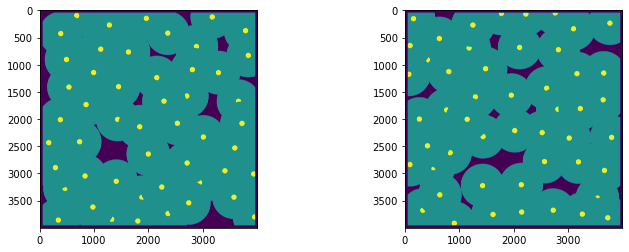

In [8]:
# 1
_, ax = plt.subplots(ncols=2, figsize=(12,4))
for i in range(2):
    ax[i].imshow(x.population[i].state)

In [9]:
display(x.population[0].genes)
# display(x.population[0].get_tuples())
display(x.population[0].genes.shape)

array([ 103,  673,  127, 3160,  153, 1951,  275, 1272,  379, 3772,  424,
       2345,  432,  381,  670, 2870,  718, 1115,  770, 1623,  833, 3821,
        908,  486, 1093, 2796, 1147,  984, 1149, 3274, 1240, 2143, 1406,
       1442, 1414,  531, 1578, 2694, 1672, 2275, 1675, 3642, 1735,  845,
       2007, 1426, 2012,  373, 2078, 2520, 2080, 3706, 2142, 1830, 2330,
       2997, 2417,  727, 2434,  161, 2531, 3575, 2642, 1987, 2807, 2699,
       2892,  283, 2950, 3393, 3008, 3921, 3045,  826, 3143, 1398, 3166,
       2927, 3248, 2235, 3272,  459, 3434, 3559, 3437, 1870, 3538, 2730,
       3615,  971, 3734, 2349, 3797, 3938, 3839, 1316, 3855,  336, 3872,
       1795])

(100,)

In [31]:
%%time
x.calc_fitnesses()

CPU times: user 407 ms, sys: 24.5 ms, total: 431 ms
Wall time: 539 ms


array([512.3177449 , 512.09458786, 510.0646875 , 512.58638214,
       508.56430893])

In [34]:
%%time
x.create_crossover()

CPU times: user 21.7 ms, sys: 6.57 ms, total: 28.3 ms
Wall time: 27.7 ms


In [35]:
for i in range(5):
    print(checkConstraints_F(x.next_population[i].get_tuples(), TURB_DIAM))

1
-1
-1
1
-1


In [36]:
x.population

array([<__main__.DNA object at 0x82237dbd0>,
       <__main__.DNA object at 0x82237db10>], dtype=object)

In [37]:
x.next_population

array([<__main__.DNA object at 0x8215769d0>,
       <__main__.DNA object at 0x821576e10>], dtype=object)